# Prosper Loan Data Exploration
## by Katarzyna Lesiuk

## Investigation Overview

The analysis is focused on (1) exploring general delinquency trends in the Prosper portfolio as well as (2) presenting the results of the analysis for two selected features - Term and Listing Category versus Loan Status variable, which is my variable of interest. 

## Dataset Overview

The Prosper Loan Data dataset contains 113,937 loans listed between 2005-11-09 and 2014-03-10 on Prosper, i.e. an online loan marketplace for borrowers and lenders.  
For each listing 81 features were initially stored in the dataset, which was reduced for the purpose of this project to 13 features.  
The features analyzed include borrower characterstics (both quantitative and qualitative in nature) as well as loan features (rate, term, status etc.)

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df_final = pd.read_csv('ProsperLoanData_clean.csv')
df_final.head()

,ListingNumber,ListingCreationDate,Term,LoanStatus,BorrowerRate,ListingCategory,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DebtToIncomeRatio,IncomeRange,CreditRating
0,193129,2007-08-26 19:09:29.263000,36,c_performing,0.1580,NaN,Self-employed,2.0,True,0.17,"$25,000-49,999",C
1,1209647,2014-02-27 08:28:07.900000,36,a_performing,0.0920,Home Improvement,Employed,44.0,False,0.18,"$50,000-74,999",A
2,81716,2007-01-05 15:00:47.090000,36,c_performing,0.2750,NaN,NaN,NaN,False,0.06,NaN,HR
3,658116,2012-10-22 11:02:35.010000,36,a_performing,0.0974,Motorcycle,Employed,113.0,True,0.15,"$25,000-49,999",A
4,909464,2013-09-14 18:38:39.097000,36,a_performing,0.2085,Home Improvement,Employed,44.0,True,0.26,"$100,000+",D


In [3]:
# recreate data types from the original analysis
# change data type from object to datetime
df_final.ListingCreationDate = pd.to_datetime(df_final.ListingCreationDate)

# convert term to ordered categorical
cat_dtype = pd.api.types.CategoricalDtype(categories=[12, 36, 60], ordered=True)
df_final.Term = df_final.Term.astype(cat_dtype)

# convert data type of 'CreditRating' to ordered categorical type
cat_dtype = pd.api.types.CategoricalDtype(categories=['HR', 'E', 'D', 'C', 'B', 'A', 'AA'], ordered=True)
df_final.CreditRating = df_final.CreditRating.astype(cat_dtype)

#convert Loan Status to ordered category

cat_dtype = pd.api.types.CategoricalDtype(categories=['a_performing', 'a_nonperforming', 'c_performing', 'c_nonperforming'], ordered=True)
df_final.LoanStatus = df_final.LoanStatus.astype(cat_dtype)

# change Income Range to ordered categorical
cat_dtype = pd.api.types.CategoricalDtype(categories=['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+'], ordered=True)
df_final.IncomeRange = df_final.IncomeRange.astype(cat_dtype)

In [4]:
# add additional year column and remove year 2005 as not representative
df_final['Year'] = df_final['ListingCreationDate'].dt.year
df_final = df_final.loc[~df_final.Year.isin(['2005'])]

## Prosper loan portfolio delinquency rate

The average delinquency rate for the Prosper portfolio is relatively high at 16.7%.  
After subsetting closed listings only, the share of delinquent listings is even higher - 30.8%.   
Since the difference was so substancial the development of delinquency rate across Loan Origination years was analyzed (see following slide).

In [5]:
#set palette for further analysis
sb.set_palette("ch:start=.2,rot=-.3")
color = sb.color_palette()[2]

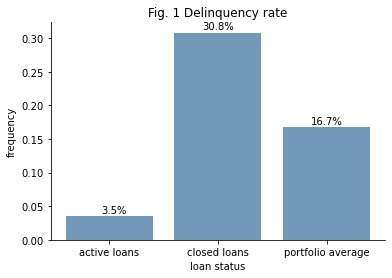

In [6]:
# calculate ratio of nonperforming to performing loans
active_ratio = df_final[df_final.LoanStatus == 'a_nonperforming'].shape[0] / (df_final[df_final.LoanStatus == 'a_performing'].shape[0] +df_final[df_final.LoanStatus == 'a_nonperforming'].shape[0])
closed_ratio = df_final[df_final.LoanStatus == 'c_nonperforming'].shape[0] / (df_final[df_final.LoanStatus == 'c_performing'].shape[0] + df_final[df_final.LoanStatus == 'c_nonperforming'].shape[0])
portfolio_ratio = (df_final[df_final.LoanStatus == 'a_nonperforming'].shape[0] + df_final[df_final.LoanStatus == 'c_nonperforming'].shape[0]) / df_final.LoanStatus.count() 

#plot bar chart
plt.bar(x=['active loans', 'closed loans', 'portfolio average'], height=[active_ratio, closed_ratio, portfolio_ratio], color=color)
plt.text(0.04, active_ratio+0.005, '{:0.1%}'.format(active_ratio), ha='center')
plt.text(1, closed_ratio+0.005, '{:0.1%}'.format(closed_ratio), ha='center')
plt.text(2, portfolio_ratio+0.005, '{:0.1%}'.format(portfolio_ratio), ha='center')
plt.ylabel('frequency')
plt.xlabel('loan status')
plt.title('Fig. 1 Delinquency rate')
sb.despine();

## Delinquency rate development
There are clear time-related trends visible for the Prosper portfolio in terms of delinquency rates.   
Between 2006-2007 the delinquency rate for the Prosper portfolio was extremely high (almost 40%).   
In 2009 however the delinquency rate improved drastically (this is the year when Prosper introduced its proprietary rating system) and in the folowing years it oscillated around 17-22% for the total portfolio and 17%-32% for the closed deals.  
The final 2 years depicted in the below figure will not be representative, as most of the Prosper deals mature after 36m, so data still includes active listings, that until final repayment can still turn out both ways.

In [7]:
#group data by listing year and loan status
annual_counts = pd.DataFrame(df_final.groupby(pd.Grouper(freq='Y', key='ListingCreationDate'))['LoanStatus'].value_counts().reset_index(name='count'))
# extract year of creation
annual_counts.ListingCreationDate = annual_counts.ListingCreationDate.astype('str').str[0:4]

In [8]:
# calculate delinquency rates for portfolio, closed listings and active listings and prepare df for visualization
ac_pivot = pd.DataFrame(annual_counts.pivot(index='ListingCreationDate', columns='LoanStatus', values='count'))
ac_pivot.columns = ac_pivot.columns.astype(str)
ac_pivot.replace(np.nan, 0, inplace=True)
ac_pivot['delinquency_rate'] = ac_pivot.apply(lambda row: (row.a_nonperforming + row.c_nonperforming) / row.sum(), axis=1)
ac_pivot['active_delinquency_rate'] = ac_pivot.apply(lambda row: row.a_nonperforming / (row.a_nonperforming + row.a_performing + 0.0001), axis=1)
ac_pivot['closed_delinquency_rate'] = ac_pivot.apply(lambda row: row.c_nonperforming / (row.c_nonperforming + row.c_performing), axis=1)

#drop unnecessary columns
ac_pivot.drop(columns=['a_performing', 'a_nonperforming', 'c_performing', 'c_nonperforming'], inplace=True)
ac_pivot.reset_index(inplace=True)

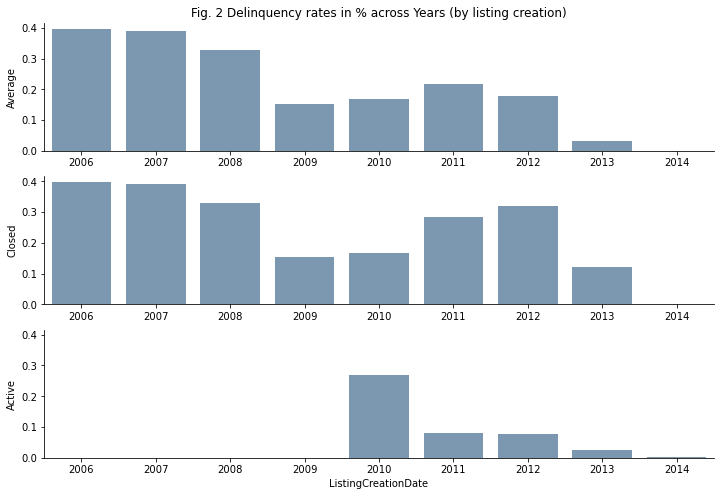

In [9]:
# generate barplot for delinquency rates
plt.figure(figsize=[12,8])

#average delinquency rate
plt1 = plt.subplot(3, 1, 1)
sb.barplot(x="ListingCreationDate", y="delinquency_rate", data=ac_pivot, color=color)
plt.title('Fig. 2 Delinquency rates in % across Years (by listing creation)')
plt.xlabel('')
plt.ylabel('Average')

# acive del rate
plt2 = plt.subplot(3, 1, 2)
sb.barplot(x="ListingCreationDate", y="closed_delinquency_rate", data=ac_pivot, color=color)
plt.ylabel('Closed')
plt.xlabel('')
plt.ylim(plt1.get_ylim())

#closed del rate
plt3 = plt.subplot(3, 1, 3)
sb.barplot(x="ListingCreationDate", y="active_delinquency_rate", data=ac_pivot, color=color)
sb.despine()
plt.ylabel('Active');
plt.ylim(plt1.get_ylim());


## Term vs Loan status

Interestingly it seems that even though the 12m category has a very good structure in terms of its share of delinquent loans (only 5% of closed loans were nonperforming) it seems to be almost discontinued, as it's share of performing observations is only 4,4%.  
The 60m category on the other hand does not have many observations in the closed categories (only 15% of the total nr of loans), and has a very good structure in terms of performance (82% of the total portfolio are active_performing, in total 92% are performing loans).   
However this might be attributed to the fact that this portfolio is relatively new (first 60m loans were originated in 2010 and started being more popular in 2011) and has a large share of new (active) loans, so this feature would have to be further observed as the transactions start to mature.

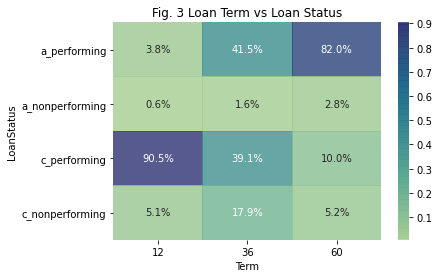

In [10]:
# create df with frequencies of each loan status per term category
df_LvT = df_final.groupby('Term')['LoanStatus'].value_counts(normalize=True)
df_LvT = df_LvT.reset_index(name='count')
df_LvT = df_LvT.pivot(index='LoanStatus', columns='Term', values='count')
#plot heatmap
sb.heatmap(df_LvT, annot=True, cmap="crest", alpha=0.8, fmt=".1%")
plt.title('Fig. 3 Loan Term vs Loan Status');

## Listing Category vs Loan Status

Debt consolidation has a better structure in terms of performance compared to the other listing categories (grouped in one bucket).  
90 % of debt consolidation listings belong to performing categories, compared to 76% among other loans.  
However the below heatmap also shows that the share of active transactions is much higher for this category, therefore this feature would have to observed more closely in the long run.

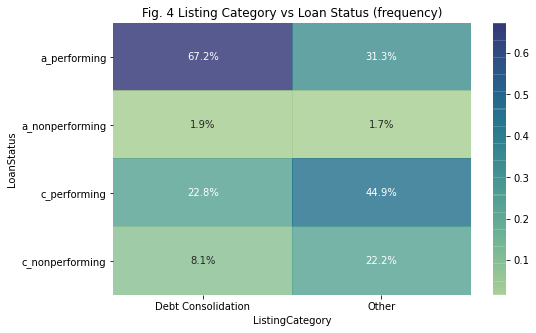

In [11]:
# replace values other than Debt consolidation with 'Other'
df_final.ListingCategory = df_final.ListingCategory.apply(lambda x: x if x == 'Debt Consolidation' else 'Other')

# create df with frequencies of each loan status per listing category
df_LvT = df_final.groupby('ListingCategory')['LoanStatus'].value_counts(normalize=True)
df_LvT = df_LvT.reset_index(name='count')
df_LvT = df_LvT.pivot(index='LoanStatus', columns='ListingCategory', values='count')
#plot heatmap
plt.figure(figsize=[8,5])
sb.heatmap(df_LvT, annot=True, cmap="crest", alpha=0.8, fmt=".1%")
plt.title('Fig. 4 Listing Category vs Loan Status (frequency)');

## Listing Category vs Term per Loan status

Looking at the performing categories (left column of Fig. 5) it is clearly visible that the 60-month loans start to make up a large share of Propsers portfolio with most of the loans being in the Debt Consolidation category.  
If we compare closed performing and nonperforming loans for the 36 month category (most representative) it is clear that the share of Debt Consolidation in the 36 month closed nonperforming is lower than for the closed performing.
Also looking at the active portfolio for both 36 and 60 month loans we can observe, that even though the count of active performing loans im much higher for Debt consolidation, the number of nonperforming listings are almost equal (or even lower) for this category than for other purpose loans, which indicates an overall healthier structure of debt consolidation loans.

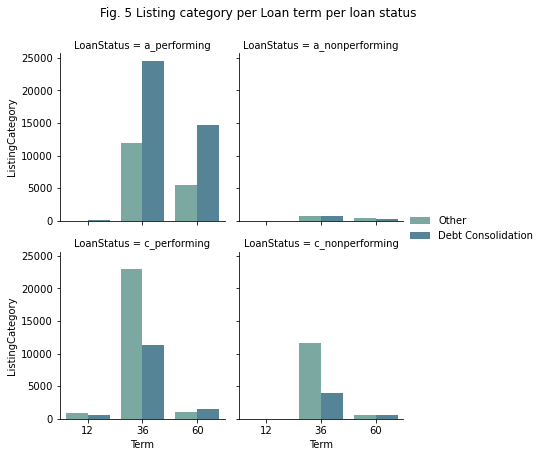

In [12]:
# define wrap up function for countplot to use in facet
def countplot(x, hue, **kwargs):
    sb.countplot(x=x, hue=hue, **kwargs)
    
# create facet grid with plots
g2 = sb.FacetGrid(data=df_final, col='LoanStatus', col_wrap=2)
fig = g2.map(countplot, 'Term', 'ListingCategory', palette='crest', alpha=0.8)
g2.fig.suptitle('Fig. 5 Listing category per Loan term per loan status', y=1.05)
fig.add_legend();

In [ ]:
!jupyter nbconvert slide_deck_loan_data.ipynb --to slides --post serve  --no-input --no-prompt